# Tensorboard Lab

Created by [JuanJo Nieto](https://www.linkedin.com/in/juan-jose-nieto-salas/) for the [Postgraduate Course in Artificial Intelligence with Deep Learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) ([UPC School](https://www.talent.upc.edu/ing/), 2021).

Updated by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/).

Update 1: 06/03/2021  
Update 2: 18/03/2021  
Update 3: 07/10/2021  

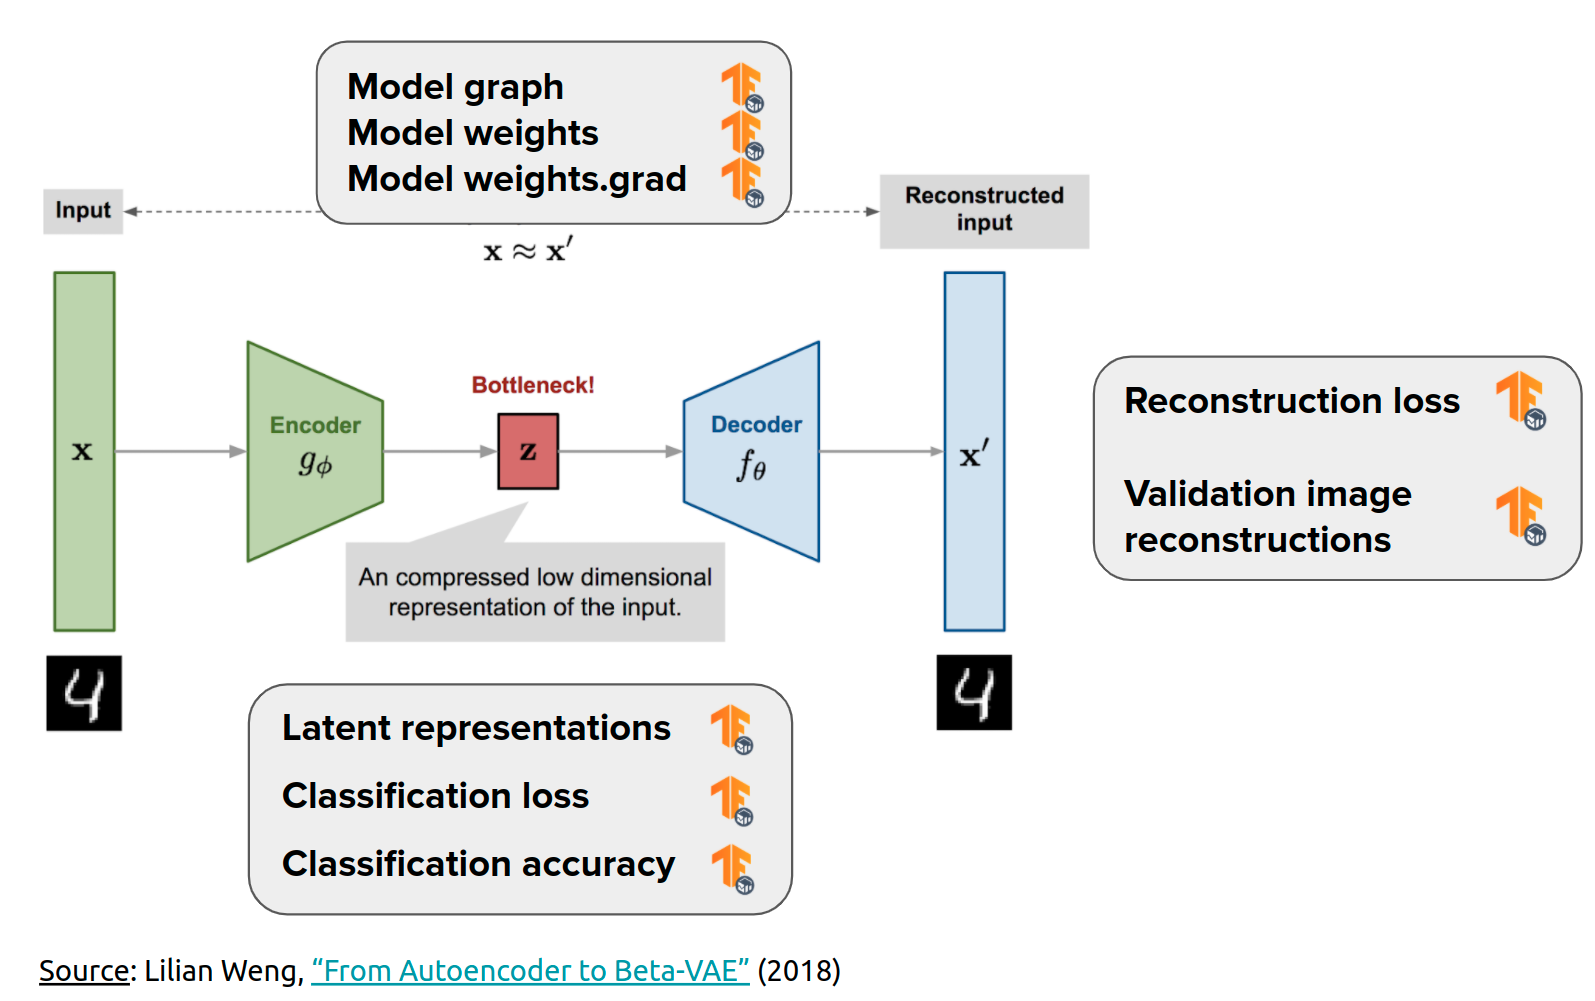

Tensorboard has many different logging options. In this lab we will explore some of the most useful features. For doing that we will train an Autoencoder to reconstruct images from MNIST dataset. And then we will attach a linear layer to the encoder to train also a classifier. With this set up will be able to log to tensorboard:


*   Model graph
*   Weights' values and gradients
*   Reconstruction Loss
*   Image reconstructions
*   Latent representations



*   Classification Loss
*   Classification Accuracy
*   Confusion Matrix



In [ ]:
import copy
import os
import numpy as np

import itertools
import tensorflow
import torch
import tensorboard
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import datetime
from time import time

from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
%load_ext tensorboard

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST

In [ ]:
# Avoid tensorboard crashing when adding embeddings 
tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile

## Make sure your runtime has a GPU


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
assert not device.type == 'cpu', "Change Runtime Type -> GPU"

# Instantiate Tensorboard Writer

First thing we have to do is to instantiate a writer that will allow us to log all type of variables. For that, we need to define a folder where all our runs will be stored.

For more info, check the [`SummaryWriter` docs](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter).

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=logdir)

# Set a fixed seed

In [ ]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Hyperparameters

In [ ]:
latent_dims = 64        # bottleneck dimension
num_epochs = 10         # training number of epochs
batch_size = 128        # size of each batch
capacity = 64           # parameter for dimensioning the NN
learning_rate = 1e-3    # learning rate
subset_len = 5120       # length of the subsets

## Create train and validation dataloaders

In [ ]:
# Download dataset
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

# Define image transformations
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define training and validation sets
train_dataset = MNIST(root='./', download=False, transform=img_transform, train=True)
val_dataset = MNIST(root='./', download=False, transform=img_transform, train=False)

# We don't need the whole dataset, we'll pick a subset
train_dataset = Subset(train_dataset, list(range(subset_len)))
val_dataset = Subset(train_dataset, list(range(subset_len)))

# To iterate over batches of data we will use these dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Define Encoder and Decoder networks

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.linear = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7)
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x))
        return x

## Join them within the AutoEncoder class

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = AutoEncoder()

In [ ]:
model

## Open the tensorboard dashboard

In [ ]:
%tensorboard --logdir logs

## **Exercise 1.  Log the model's graph to tensorboard**

Use the writer's [`add_graph`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph) method.

In [ ]:
# take one batch from the training loader
batch, _ = next(iter(train_dataloader))

# TODO: Log the model's graph to tensorboard. Remember that you need to pass a batch of data along with the model
writer...

In [ ]:
# Put the model in the GPU
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

## **Exercises 2-4.  Training the Autoencoder**

Execute the training of the Autoencoder. Send the following information to the writer:
- Train and validation reconstruction losses
- Weights and gradients histograms
- Reconstructed images from validation set

You can use the writer's [`add_scalar`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalar), [`add_histogram`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram) and [`add_image`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_image),  methods.

In [ ]:
def forward_image(image_batch):
    image_batch = image_batch.to(device)
    image_batch_recon = model(image_batch)
    return F.mse_loss(image_batch_recon, image_batch), image_batch_recon

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)


ini = time()
for epoch in range(num_epochs):
    
    train_loss = []
    val_loss = []    

    model.eval()
    for i,(image_batch, _) in enumerate(val_dataloader):
        with torch.no_grad():
            loss, recon = forward_image(image_batch)
            if i == 0:

                # make_grid returns an image tensor from a batch of data (https://pytorch.org/vision/stable/utils.html#torchvision.utils.make_grid)
                grid = make_grid(recon)

                # TODO: Log a batch of reconstructed images from the validation set. Use the grid variable defined above.
                writer...

            val_loss.append(loss.item())
        
    val_loss_avg = np.mean(val_loss)

    # TODO: Log validation reconstruction loss to tensorboard. Tip: use "Reconstruction/val_loss" as tag
    writer...


    model.train()
    for image_batch, _ in train_dataloader:
        
        loss, _ = forward_image(image_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
    
    train_loss_avg = np.mean(train_loss)

    # TODO: Log train reconstruction loss to tensorboard. Tip: use "Reconstruction/train_loss" as tag
    writer...

    for name, weight in model.encoder.named_parameters():
        # TODO: Log the weights' values and grads histograms. Tip: use "{name}/value" and "{name}/grad" as tags
        writer...
        writer...
    
    print(f"Epoch [{epoch} / {num_epochs}] average reconstruction error: {train_loss_avg}")

print(f"Training took {time()-ini} seconds")

## **Exercise 5.  Log latent representations**

Use the writer's [`add_embedding`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_embedding) method.

In [ ]:
# take a few batches from the training loader
list_latent = []
list_images = []
for i in range(10):
    batch, _ = next(iter(train_dataloader))

    # forward batch through the encoder
    list_latent.append(model.encoder(batch.to(device)))
    list_images.append(batch)

latent = torch.cat(list_latent)
images = torch.cat(list_images)

# TODO: Log latent representations (embeddings)
writer...

# Be patient! Projector logs can take a while

## Define Classifier module

We are going to use the latent representations to classify MNIST.

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.encoder = Encoder()
    self.linear = nn.Linear(latent_dims, 10)

  def forward(self, x):
    x = self.encoder(x)
    return self.linear(x)

Copy the encoder weights from AutoEncoder to our Classifier

In [ ]:
classifier = Classifier().to(device)
classifier.encoder = copy.deepcopy(model.encoder)

In [ ]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
def compute_accuracy(preds, labels):
    pred_labels = preds.argmax(dim=1, keepdim=True)
    acc = pred_labels.eq(labels.view_as(pred_labels)).sum().item()/len(pred_labels)
    return acc

def log_confusion_matrix(preds, labels):
    predictions = preds.argmax(dim=1, keepdim=True)
    
    cm = confusion_matrix(labels.cpu(), predictions.cpu())
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    fig = plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='none', cmap=plt.cm.Blues)

    plt.colorbar()
    tick_marks = np.arange(10)

    plt.xticks(tick_marks, np.arange(0,10))
    plt.yticks(tick_marks, np.arange(0,10))

    plt.tight_layout()
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion matrix")
    return fig

## **Exercise 6-7. Training the Classifier**

Execute the training of the Classifier. Send the following information to the writer:
- Train and validation classification losses
- Train and validation classification accuracies
- Confusion matrix

Use the writer's [`add_scalar`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalar) and [`add_figure`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure) methods.

In [ ]:
for epoch in range(num_epochs):

    classifier.eval()
    val_loss_epoch = []
    val_acc_epoch = []
    with torch.no_grad():
        for image_batch, label_batch in val_dataloader:

            img, label = image_batch.to(device), label_batch.to(device)
            predictions = classifier(img)
            loss = criterion(predictions, label.long())
            
            val_loss_epoch.append(loss.item())
            val_acc_epoch.append(compute_accuracy(predictions, label))

        fig = log_confusion_matrix(predictions, label)
        mean_loss = np.mean(val_loss_epoch)
        mean_acc = np.mean(val_acc_epoch)

        # TODO: Log confusion matrix figure to tensorboard
        writer...

        # TODO: Log validation loss to tensorboard. Tip: use "Classification/val_loss" as tag
        writer...

        # TODO: Log validation accuracy to tensorboard. Tip: use "Classification/val_acc" as tag
        writer...
        

    classifier.train()
    loss_epoch = []
    acc_epoch = []
    for image_batch, label_batch in train_dataloader:
        
        img, label = image_batch.to(device), label_batch.to(device)
        predictions = classifier(img)
        loss = criterion(predictions, label.long())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_epoch.append(loss.item())     
        acc_epoch.append(compute_accuracy(predictions, label))

        
    mean_loss = np.mean(loss_epoch)
    mean_acc = np.mean(acc_epoch)


    # TODO: Log training loss to tensorboard. Tip: use "Classification/train_loss" as tag
    writer...

    # TODO: Log training accuracy to tensorboard. Tip: use "Classification/train_acc" as tag
    writer...
   
    
    print(f"Train Epoch: {epoch} Loss: {mean_loss} Acc: {mean_acc}")

In [ ]:
# Optional: re-open the tensorboard dashboard
%tensorboard --logdir logs